In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=5fe133ed502fa285e7a6abc1b80d3d6a2f69aa5aef4261d07e5e602584857a38
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_set, format_number, max
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder\
  .master("local")\
  .appName("Pyspark_SQL")\
  .config("spark.ui.port", '4050')\
  .getOrCreate()
df = spark.read.option("Header", True).csv("/content/Air_Traffic_Passenger_Statistics.csv")

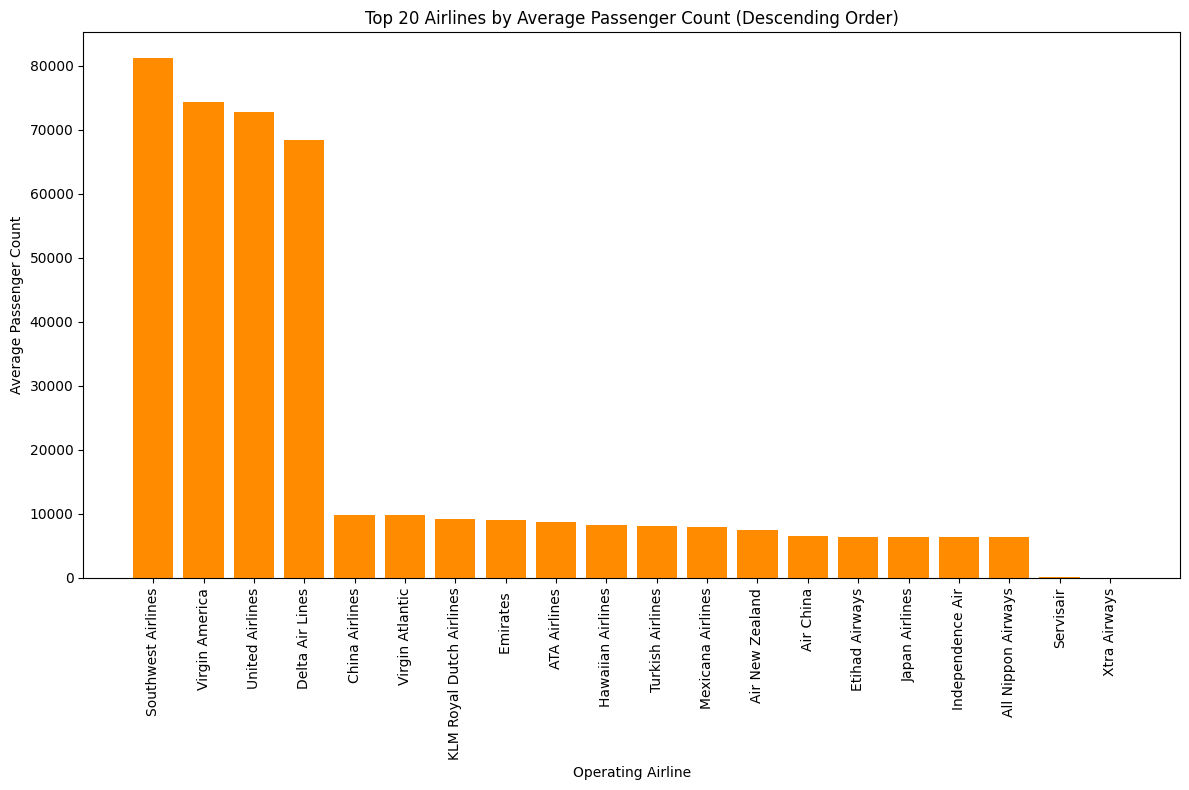

In [5]:
from pyspark.sql.functions import col, avg, format_number
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd


spark = SparkSession.builder.appName("Airlines Analysis").getOrCreate()
df = df.withColumn("Passenger Count", col("Passenger Count").cast("integer"))

result = df.groupBy("Operating Airline").avg("Passenger Count")

result = result.withColumn("avg(Passenger Count)", format_number(col("avg(Passenger Count)"), 2))

result_ordered = result.orderBy(col("avg(Passenger Count)").desc()).limit(20)

result_pd = result_ordered.toPandas()

result_pd['avg(Passenger Count)'] = result_pd['avg(Passenger Count)'].str.replace(',', '').astype(float)

result_pd_sorted = result_pd.sort_values(by='avg(Passenger Count)', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(result_pd_sorted['Operating Airline'], result_pd_sorted['avg(Passenger Count)'], color='darkorange')

plt.xlabel('Operating Airline')
plt.ylabel('Average Passenger Count')
plt.title('Top 20 Airlines by Average Passenger Count (Descending Order)')
plt.xticks(rotation=90)  # Rotación para mejorar la legibilidad

# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

# Detener la sesión de Spark al finalizar
spark.stop()


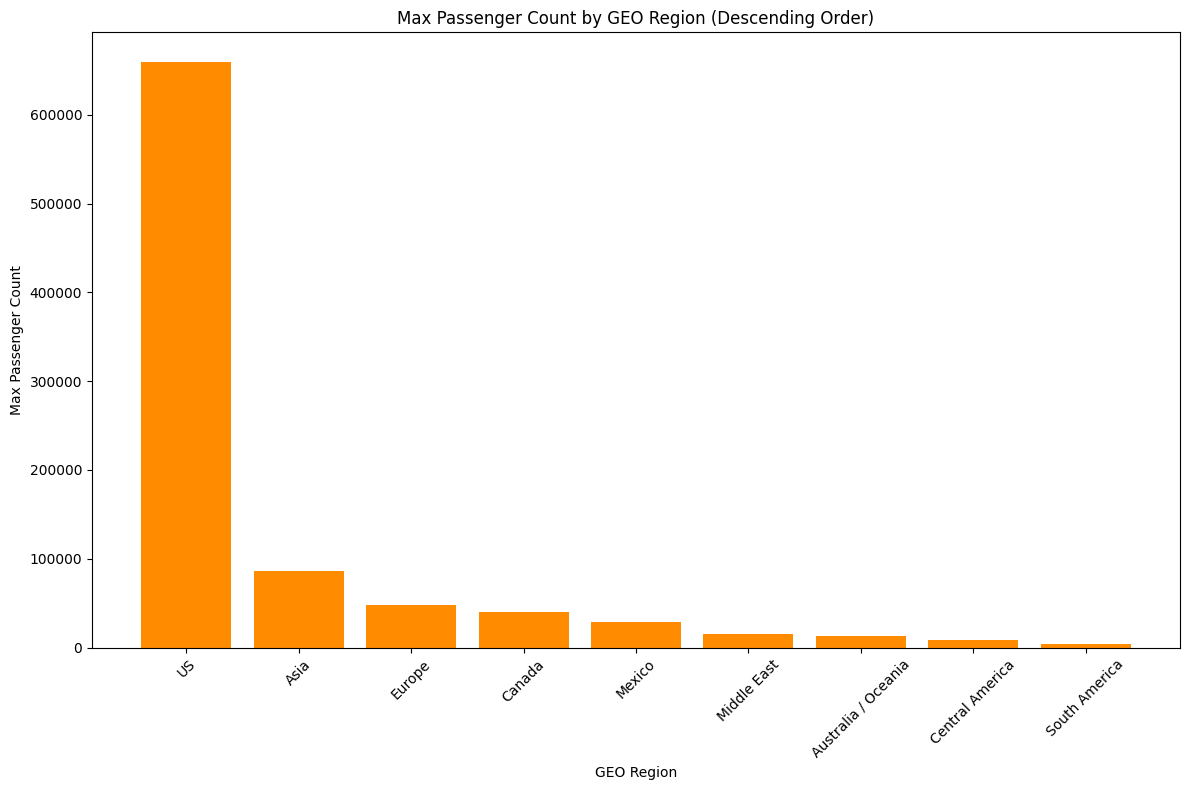

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_set, format_number, max
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder\
  .master("local")\
  .appName("Pyspark_SQL")\
  .config("spark.ui.port", '4050')\
  .getOrCreate()
df = spark.read.option("Header", True).csv("/content/Air_Traffic_Passenger_Statistics.csv")

df = df.withColumn("Passenger Count", col("Passenger Count").cast("integer"))
result = df.groupBy("GEO Region").agg(max("Passenger Count")\
                                               .alias("Max Passenger Count"))


result_ordered = result.orderBy(col("Max Passenger Count").desc())

# Convertir el DataFrame de PySpark a un DataFrame de pandas para la visualización
result_pd = result_ordered.toPandas()

spark.stop()

# Visualización con matplotlib
plt.figure(figsize=(12, 8))
plt.bar(result_pd['GEO Region'], result_pd['Max Passenger Count'], color='darkorange')
plt.xlabel('GEO Region')
plt.ylabel('Max Passenger Count')
plt.title('Max Passenger Count by GEO Region (Descending Order)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

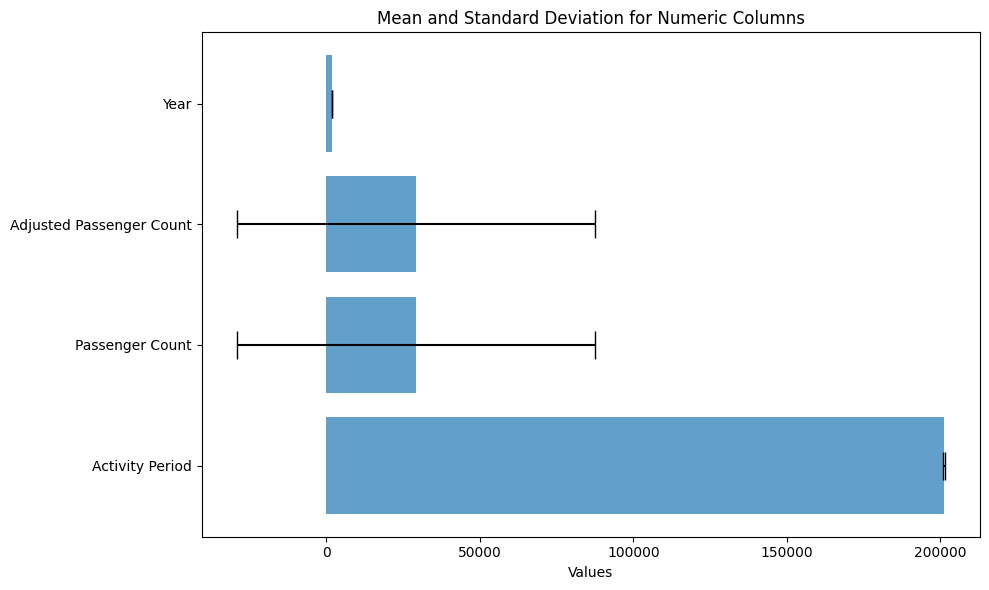

In [19]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_set, format_number, max, mean, stddev
import pandas as pd
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

spark = SparkSession.builder\
  .master("local")\
  .appName("Pyspark_SQL")\
  .config("spark.ui.port", '4050')\
  .getOrCreate()
df = spark.read.option("Header", True).csv("/content/Air_Traffic_Passenger_Statistics.csv")

from pyspark.sql.functions import mean, stddev
import matplotlib.pyplot as plt

means = []
stddevs = []
labels = []

columns_to_cast = ['Activity Period', 'Passenger Count', 'Adjusted Passenger Count', 'Year']

for column in columns_to_cast:
    df = df.withColumn(column, col(column).cast('double'))

numeric_columns = [column for column, dtype in df.dtypes if dtype in ["int", "double", "float"]]

for column in numeric_columns:
    stats = df.select(mean(col(column)).alias('mean'), stddev(col(column)).alias('stddev')).collect()[0]
    means.append(stats['mean'])
    stddevs.append(stats['stddev'])
    labels.append(column)


fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(labels, means, xerr=stddevs, align='center', alpha=0.7, ecolor='black', capsize=10)
ax.set_xlabel('Values')
ax.set_title('Mean and Standard Deviation for Numeric Columns')
plt.tight_layout()
plt.show()

spark.stop()

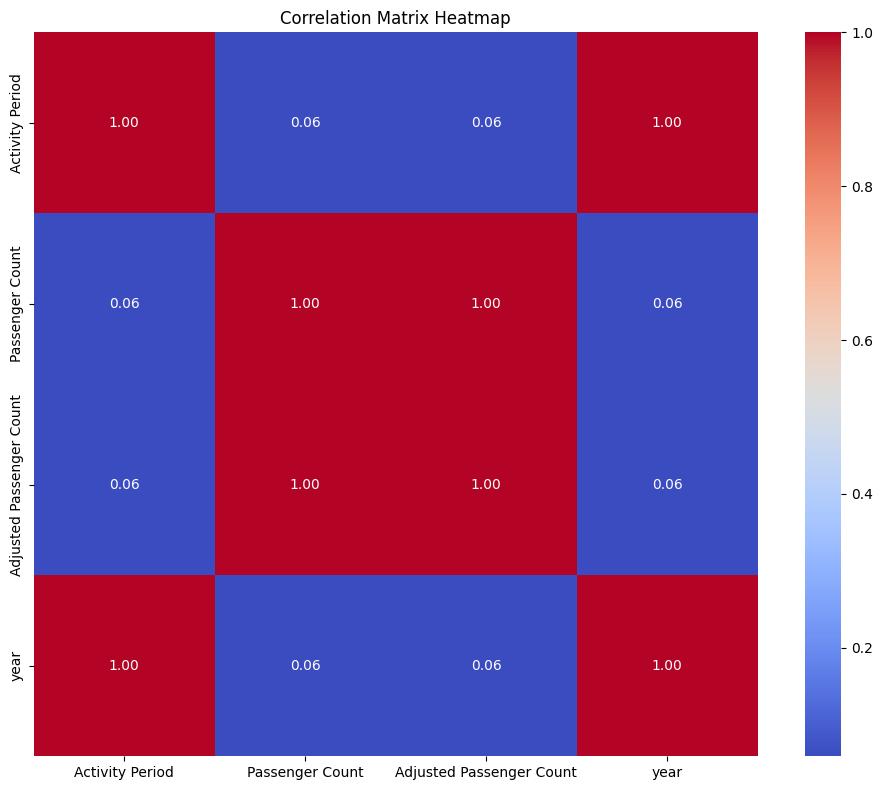

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_set, format_number, max
import pandas as pd
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
import seaborn as sns

spark = SparkSession.builder\
  .master("local")\
  .appName("Pyspark_SQL")\
  .config("spark.ui.port", '4050')\
  .getOrCreate()
df = spark.read.option("Header", True).csv("/content/Air_Traffic_Passenger_Statistics.csv")

columns_to_cast = ['Activity Period', 'Passenger Count', 'Adjusted Passenger Count', 'year']

for column in columns_to_cast:
    df = df.withColumn(column, col(column).cast('double'))

numeric_columns = [column for column, dtype in df.dtypes if dtype in ['double', 'float', 'int']]
correlation_matrix = []


for x in numeric_columns:
    row = []
    for y in numeric_columns:
        row.append(df.stat.corr(x, y))
    correlation_matrix.append(row)
correlation_df = pd.DataFrame(correlation_matrix, columns=numeric_columns, index=numeric_columns)


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

      Passenger Count     prediction
0             27271.0   26667.660915
1             29131.0   28542.641119
2             34090.0   33983.040785
3             12050.0   11984.148165
4              7977.0    8224.982337
...               ...            ...
2996           8865.0    8833.009261
2997         263407.0  263949.435865
2998            169.0   -1202.406536
2999            114.0   -1109.196475
3000          67286.0   67056.294789

[3001 rows x 2 columns]


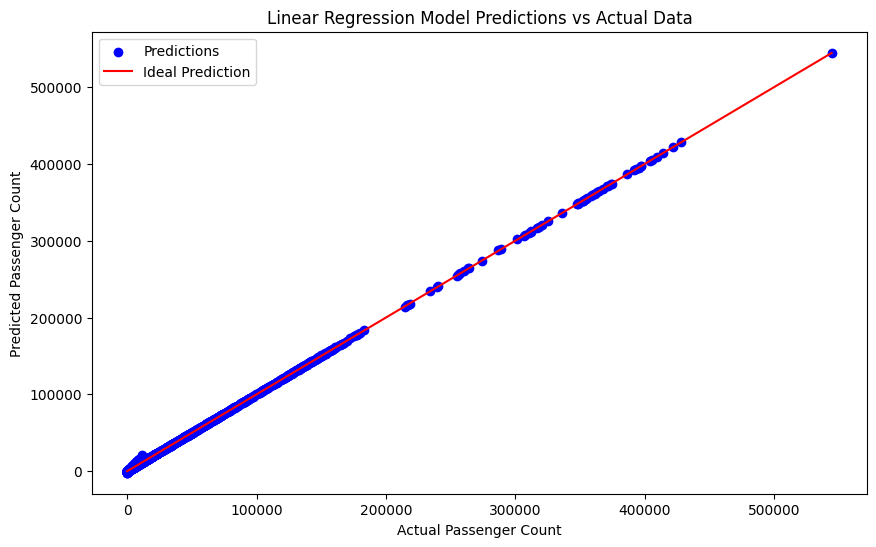

In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

spark = SparkSession.builder\
  .master("local")\
  .appName("Pyspark_SQL")\
  .config("spark.ui.port", '4050')\
  .getOrCreate()
df = spark.read.option("Header", True).csv("/content/Air_Traffic_Passenger_Statistics.csv")


columns_to_cast = ['Activity Period', 'Passenger Count', 'Adjusted Passenger Count', 'Year']
all_columns = df.columns
for column in columns_to_cast:
    df = df.withColumn(column, col(column).cast('double'))

numeric_columns = ['Activity Period', 'Adjusted Passenger Count', 'Year']
categorical_columns = [col for col in all_columns if col not in columns_to_cast]

indexers = [
    StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep")
    for c in categorical_columns
]

encoders = [
    OneHotEncoder(inputCol=c+"_index", outputCol=c+"_vec")
    for c in categorical_columns
]

assemblerInputs = [c + "_vec" for c in categorical_columns] + numeric_columns

vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

lr = LinearRegression(featuresCol="features", labelCol="Passenger Count")

pipeline = Pipeline(stages=indexers + encoders + [vecAssembler, lr])

(train_data, test_data) = df.randomSplit([0.8, 0.2])
model = pipeline.fit(train_data)

predictions = model.transform(test_data)
evaluator_rmse = RegressionEvaluator(labelCol="Passenger Count", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Passenger Count", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

predictions_pd = predictions.select("Passenger Count", "prediction").toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['Passenger Count'], predictions_pd['prediction'], color='blue', label='Predictions')
plt.plot([predictions_pd['Passenger Count'].min(), predictions_pd['Passenger Count'].max()], [predictions_pd['Passenger Count'].min(), predictions_pd['Passenger Count'].max()], color='red', label='Ideal Prediction')
plt.title('Linear Regression Model Predictions vs Actual Data')
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.legend()
plt.show()

